In [1]:
import sys, pickle
sys.path.insert(0, "libs")

import networkx as nx
import numpy as np
from scipy.stats import binom as binDist
from scipy.stats import binom as binomialDistribution
from scipy.interpolate import make_interp_spline
from matplotlib import pyplot as plt
from scipy.special import binom
from itertools import product

import matplotlib.colors as mcolors
from libs.utils import *

In [2]:
def expected_minimum_binomial(m, n, p):
    # Calculate P(X_i >= k) for each k
    prob_x_geq_k = np.array([sum(binDist.pmf(range(k, n+1), n, p)) for k in range(n+1)])

    # Calculate P(Y = k) for each k (Y being the minimum of m draws)
    prob_y_eq_k = np.zeros(n+1)
    for k in range(n+1):
        if k == n:
            prob_y_eq_k[k] = prob_x_geq_k[k] ** m
        else:
            prob_y_eq_k[k] = prob_x_geq_k[k] ** m - prob_x_geq_k[k+1] ** m

    # Calculate the expected value E[Y]
    expected_value_y = np.sum([k * prob_y_eq_k[k] for k in range(n+1)])
    
    return expected_value_y

def plot_binomial_with_truncated_shifted(n, p, i, colors=None, plot=False):

    # set colors
    if colors is None:
        colors = list((mcolors.TABLEAU_COLORS).values())
    
    # Binomial distribution
    x = np.arange(0, n+1)
    binomial_probs = binomialDistribution.pmf(x, n, p)
    if plot: 
        plt.plot(x, binomial_probs, color='gray', lw=0, marker='x')
    
    # Spline interpolation of the binomial distribution
    grid = 1000
    num_points = n*grid
    x_spline = np.linspace(0, n, num_points)  # More points for a smooth spline
    spline = make_interp_spline(x, binomial_probs, k=3)
    binomial_spline = spline(x_spline)

    # normalize a binomial spline
    binomial_spline = binomial_spline/np.sum(binomial_spline)*grid

    # intialize max degrees array
    max_degrees = np.zeros(i)
    
    # remove maximum-degree nodes, one at a time
    for j in range(i):

        if plot:
            plt.plot(x_spline, binomial_spline, label='removed {}'.format(j), color=colors[j%len(colors)])
            
        # find truncation point
        cumulative_spline = np.cumsum(binomial_spline[::-1])[::-1]
        k_star_index = np.where(cumulative_spline <= 1/n*(grid))[0][0]
        k_star = x_spline[k_star_index]
        if plot:
            plt.axvline(x=k_star, color=colors[j%len(colors)], linestyle='--', label=r'$k_j* = {:.3f}$'.format(k_star, j))


        mean_k = np.sum(x_spline*binomial_spline)/grid
        m = mean_k*(n-j)/2
        print('(mean_k, m) = ({:.3f},{:.3f})'.format(mean_k, m))

        # Truncate right at kmax 
        truncated_spline = np.copy(binomial_spline)
        truncated_spline[k_star_index + 1:] = 0  # Truncate at k*
    
        # shift distribution        
        c = ((n-j)*k_star-(n-1-j)*mean_k)/(k_star-mean_k)/binom(n-j,2)
        #c = 
        shifts = c*np.arange(len(truncated_spline))/(grid)
        #print('shufts',shifts)
        x_truncated_spline = x_spline - shifts
    
        # truncate left at zero
        num_negatives = sum(x_truncated_spline < 0)
        x_truncated_spline = x_truncated_spline[num_negatives:]
        truncated_spline[num_negatives] += np.sum(truncated_spline[:num_negatives])/grid
        truncated_spline = truncated_spline[num_negatives:]
   
        # normalize again        
        truncated_spline = truncated_spline /np.sum(truncated_spline)*grid

        x_spline = x_truncated_spline
        binomial_spline = truncated_spline
        print('(max_k, m-max_k, new m) = ({:.3f},{:.3f},{:.3f})'.format(k_star, m-k_star, 
            np.sum(x_spline*binomial_spline)/grid*(n-j)/2))
        max_degrees[j] = k_star

    if plot:
        plt.legend()

    return max_degrees

(mean_k, m) = (4.018,40.184)
(max_k, m-max_k, new m) = (7.116,33.068,33.825)
(mean_k, m) = (3.382,32.134)
(max_k, m-max_k, new m) = (5.686,26.448,26.683)
(mean_k, m) = (2.809,25.279)
(max_k, m-max_k, new m) = (4.569,20.710,20.306)
(mean_k, m) = (2.256,19.178)
(max_k, m-max_k, new m) = (3.588,15.590,14.558)
(mean_k, m) = (1.713,13.701)
(max_k, m-max_k, new m) = (2.677,11.024,9.359)
(mean_k, m) = (1.170,8.774)
(max_k, m-max_k, new m) = (1.804,6.970,4.660)
(mean_k, m) = (0.621,4.349)
(max_k, m-max_k, new m) = (0.948,3.401,0.422)


array([7.11635582, 5.68560747, 4.56884372, 3.58758783, 2.67700102,
       1.80415304, 0.947721  ])

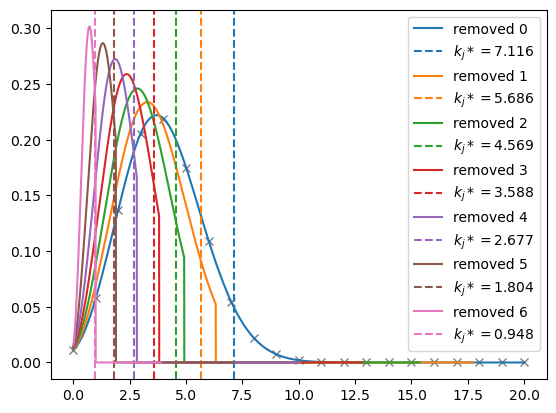

In [3]:
plot_binomial_with_truncated_shifted(20, 0.2, 7, plot=True)

0.5000, 0.5000
estimated old m 14.0
0.4187, 0.4128
estimated old m 8.66787175772119
0.3634, 0.3048
estimated old m 4.571600109008778
0.3090, 0.1723
estimated old m 1.7231501512149539
0.2364, 0.0211
estimated old m 0.1263197255260935
0.2187, 0.0000
estimated old m 0.0
0.0280, 0.0000


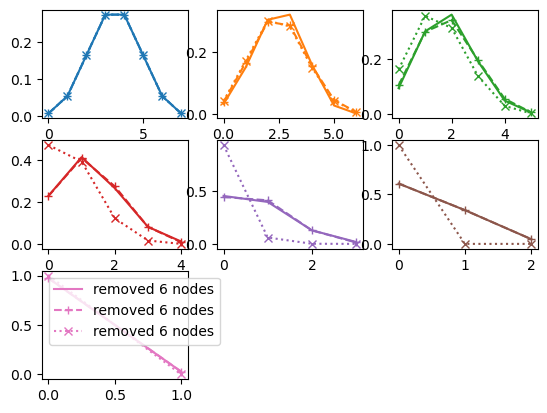

In [66]:
n0=8
p0=0.5
tab10 = list(mcolors.TABLEAU_COLORS.values())

file = open(r'exact_degree_distributions_n{}_p{:.2f}.txt'.format(n0,p0), 'r')
distributions = []
for line in file:
    numbers = [float(val) for val in line.split()]
    distributions += [np.array(numbers)]  

p2 = p0
p_values = np.zeros((2,n0))
distributions_for_plots=np.zeros((3,n0), dtype=object)

for i in range(len(distributions)):
    plt.subplot(3,3,i+1)
    n = n0 - i
    # exact distribution
    plt.plot(distributions[i]/n, color=tab10[i], label=r'removed {} nodes'.format(i))
    distributions_for_plots[0,i] = distributions[i]/n

    # comparable binomial
    mean_k = np.sum(distributions[i]/n*np.arange(len(distributions[i])))   
    p = mean_k*n/2/binom(n,2)
    binomial_probs = binomialDistribution.pmf(np.arange(0, n), n-1, p)
    plt.plot(binomial_probs, '--', marker='+', color=tab10[i], label=r'removed {} nodes'.format(i))
    distributions_for_plots[1,i] = binomial_probs

    # comparable binomial with estimated kmax
    binomial_probs = binomialDistribution.pmf(np.arange(0, n), n-1, p2)
    plt.plot(binomial_probs, ':', marker='x', color=tab10[i], label=r'removed {} nodes'.format(i))
    distributions_for_plots[2,i] = binomial_probs
    print(r'{:.4f}, {:.4f}'.format(p, p2))

    # save results
    p_values[0,i] = p
    p_values[1,i] = p2

    # calculate p' for next step
    p2 = edgeProbabilityAfterTargetedAttack(n, p2)

plt.legend()

In [57]:
distributions_for_plots=np.zeros((3,n0), dtype=object)
distributions_for_plots[0,0]=[0,1,2]
distributions_for_plots

array([[list([0, 1, 2]), 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0]], dtype=object)

0
1
2
3
4
5


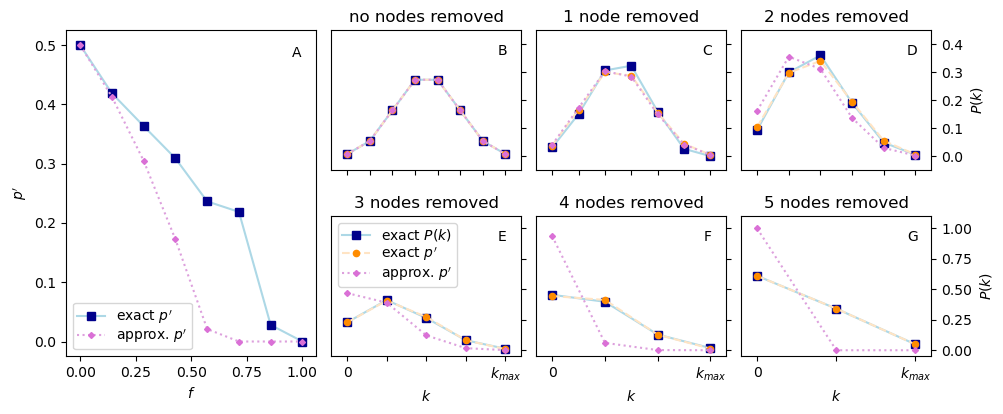

In [151]:
# Create a figure with the specified width and height
fig = plt.figure(figsize=(10, 4.))
large_width= 0.25
small_width = 0.19
small_height = 0.35
dx, dy = 0.015, 0.115
x0, y0 = 0.06, 0.125

# Add the first subplot 
ax1 = fig.add_axes([x0, y0, large_width, 0.94-y0])  # [left, bottom, width, height]
#ax1.set_title('Subplot 1')
ax1.set_xlabel(r"$f$")
ax1.set_ylabel(r"$p'$")
ax1.set_xlim([0-0.5/n0, 1+0.5/n0])
ax1.text(0.92,0.93,'(a)',  ha='center', va='center', transform=ax1.transAxes)

xvals = np.linspace(0,1,n0)
plt.plot(xvals, p_values[0], marker='s', color='lightblue', mec='darkblue', mfc='darkblue', label=r"exact $p'$")
plt.plot(xvals, p_values[1], marker='D', ms=3, ls=':', color='plum', mec='orchid', mfc='orchid', label=r"approx. $p'$")
plt.legend(loc=3, labelspacing = 0.05, borderpad=0.3)

axes = (np.zeros(6)).tolist()
for ri in range(2):
    for ci in range(3):
    
        data_index = 3*ri+ci
        print(data_index)
        # Add the second subplot (semi-full height, 20% width, top)
        axes[data_index] = fig.add_axes([x0+large_width+(ci+1)*dx+ci*(small_width), 
                           y0+(1-ri)*(small_height+dy), 
                           small_width, small_height])  # [left, bottom, width, height]
        ax = axes[data_index]
        if data_index == 0:
            ax.set_title(r'no nodes removed'.format(data_index))
        elif data_index == 1:
            ax.set_title(r'{} node removed'.format(data_index))
        else:
            ax.set_title(r'{} nodes removed'.format(data_index))
        #print(distributions_for_plots[0,data_index])
        xvals = np.linspace(0,1,len(distributions_for_plots[0,data_index]))
        axes[data_index].plot(xvals,distributions_for_plots[0,data_index], 
            marker='s', ms=6, color='lightblue', mec='darkblue', mfc='darkblue', label=r'exact $P(k)$')
        axes[data_index].plot(xvals,distributions_for_plots[1,data_index], 
            ls='--', marker='o', ms=4.5, color='bisque', mec='darkorange', mfc='darkorange', label=r"exact $p'$")
        axes[data_index].plot(xvals,distributions_for_plots[2,data_index], 
            ls=':', marker='D', ms=3, color='plum', mec='orchid', mfc='orchid', label=r"approx. $p'$")
        ax.set_xticklabels([])
        ax.set_xlim([-0.1,1.1])
        
        ax.set_xticks(xvals)
        xticks = ['' for x in xvals]

        if ri==1:
            ax.set_xlabel(r'$k$')
            xticks[0]='0'
            xticks[-1] = r'$k_{max}$'
            ax.set_xticklabels(xticks)
            ax.set_ylim([-0.05,1.1])
        else:
            ax.set_xticklabels([])
            ax.set_ylim([-0.05,0.45])

        if ci==2:
            ax.yaxis.tick_right()
            ax.yaxis.set_label_position('right')
            ax.set_ylabel(r'$P(k)$')
        else:
            ax.yaxis.tick_right()
            ax.set_yticklabels([])

        ax.text(0.9,0.85, "(" + 'bcdefg'[data_index] + ")",  ha='center', va='center', transform=ax.transAxes)
        if data_index==3:
            plt.legend(labelspacing = 0.05, borderpad=0.3)

plt.savefig('binomial-attack.pdf')
